# Dicom Pre-Processing

The sources used to process the data:
- [Source 1](https://www.kaggle.com/code/gzuidhof/full-preprocessing-tutorial)
- [Source 2](https://www.kaggle.com/code/allunia/pulmonary-dicom-preprocessing)
- [Source 3](https://github.com/theodapamede/dicom_preprocessing/blob/main/embed_data_preprocessing/embed_data_preprocessing.ipynb)


In [60]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns

Read Files

In [61]:
def read_dicom(folder_path) -> list[pydicom.FileDataset]:
    dicom_list = glob.glob(f"{folder_path}/*.dcm")
    dicom_list.sort()
    dicom_files = []
    for file in dicom_list:
        dicom_files.append(pydicom.dcmread(file))
    return dicom_files
    

In [62]:
files = read_dicom("../data/raw")

In [63]:
print(len(files))
print(files[0])

626
Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 198
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.296485632.1.1731597629.926147
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.8
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_368'
-------------------------------------------------
(0008,0000) Group Length                        UL: 216
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.296485632.1.1731597629.926147
(0008,0020) Study Date                          DA: ''
(0

In [64]:
print(files[0].pixel_array.shape)
print(files[0].pixel_array.flatten().shape)
print(files[0].RescaleSlope)
print(files[0].RescaleIntercept)

(512, 512)
(262144,)
1
0


plotting pixel dist

1
0
1
0
1
0
1
0
1
0


Text(0.5, 1.0, 'HU unit distributions for 5 examples')

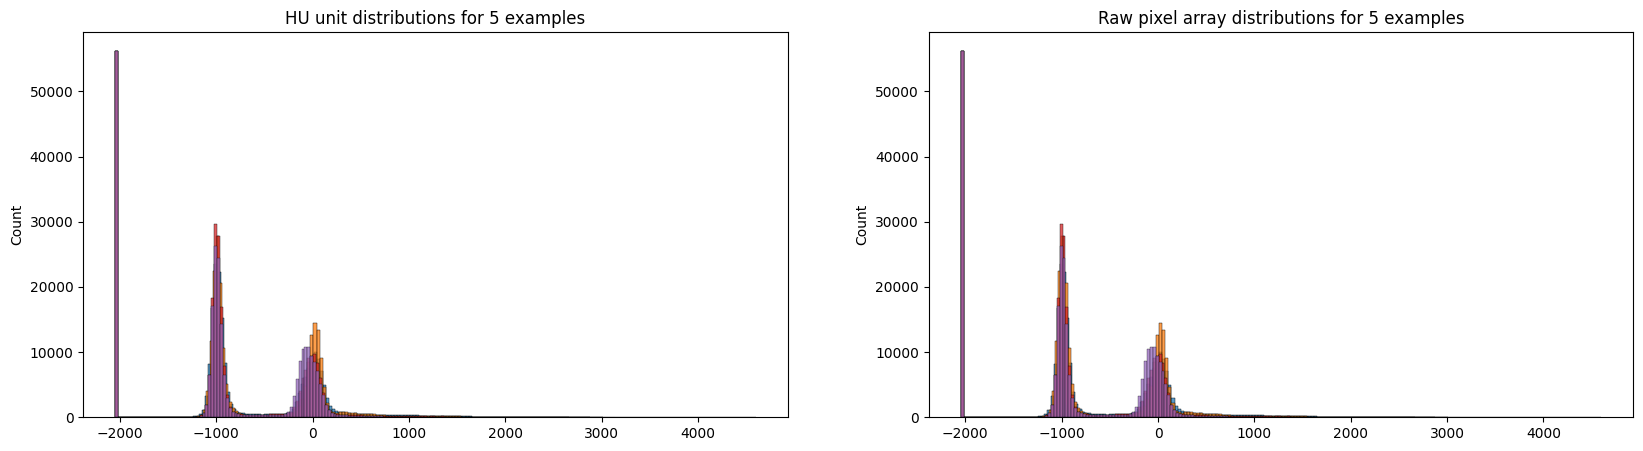

In [65]:
fig,axis = plt.subplots(1,2,figsize=(20,5))
for i in range(10,15):
    img= files[i].pixel_array.flatten()
    print(files[i].RescaleSlope)
    print(files[i].RescaleIntercept)
    scaled = img * files[i].RescaleSlope + files[i].RescaleIntercept
    sns.histplot(scaled.flatten(), ax = axis[0])
    sns.histplot(img.flatten(), ax = axis[1])
axis[1].set_title("Raw pixel array distributions for 5 examples")
axis[0].set_title("HU unit distributions for 5 examples")

### examining the slope and intercept for all files, as the plot suggests that sample is already in HU space

In [66]:
inter = set()
slope = set()
cnt = 0
for file in files:
    inter.add(file.RescaleIntercept)
    if file.RescaleIntercept:
        cnt+=1
    slope.add(file.RescaleSlope)

[print(i) for i in inter]
[print(i) for i in slope]
len(inter), len(slope), cnt

0
-1024
1


(2, 1, 392)

### checking the scan type

In [67]:
set(ds.Modality for ds in files)


{'CT'}

### visualizing random sample for understanding

<Axes: ylabel='Count'>

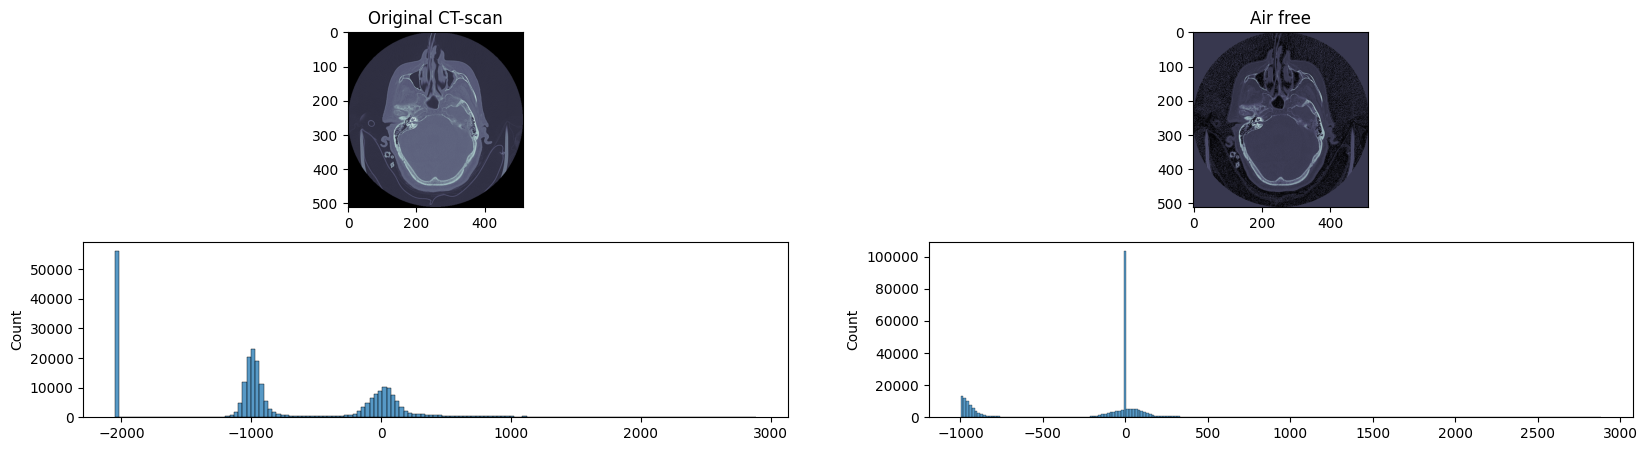

In [68]:
fig,ax = plt.subplots(2,2,figsize = (20,5))


ax[0,0].set_title("Original CT-scan")
ax[0,0].imshow(files[7].pixel_array, cmap="bone")
sns.histplot(files[7].pixel_array.flatten(),ax=ax[1,0])

airfree = files[7].pixel_array
airfree[files[7].pixel_array <= -1000] = 0

ax[0,1].set_title("Air free")
ax[0,1].imshow(airfree, cmap="bone")
sns.histplot(airfree.flatten(),ax=ax[1,1])

In [69]:
def free_air(pixels):
    pixels[pixels<=-1000]=0
    return pixels

In [ ]:
def turn_hu(files: list[pydicom.FileDataset]):
    pixels = np.stack([i.pixel_array.astype(np.int16).copy() for i in files])
    pixels = free_air(pixels)
    print(pixels.shape, pixels.dtype)
    for i in range(len(files)):
        pixels[i]+= np.int16(files[i].RescaleIntercept)
    return np.array(pixels)
    

In [71]:
hu_files = turn_hu(files)

(626, 512, 512) int16


<Axes: ylabel='Count'>

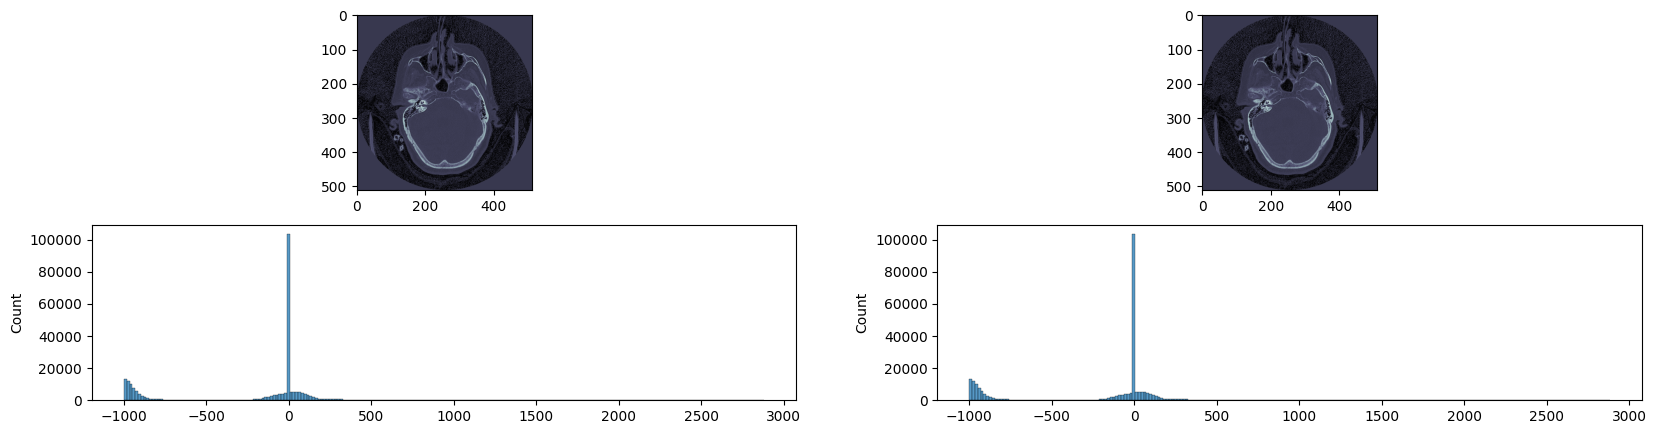

In [72]:
fig,ax = plt.subplots(2,2,figsize = (20,5))
ax[0,0].imshow(files[7].pixel_array, cmap="bone")
sns.histplot(files[7].pixel_array.flatten(),ax=ax[1,0])
ax[0,1].imshow(hu_files[7], cmap="bone")
sns.histplot(hu_files[7].flatten(),ax=ax[1,1])